### Fetch Tweets from MongoDB Collection

In [ ]:
from sshtunnel import SSHTunnelForwarder
import pymongo
import pprint

MONGO_HOST = "128.226.28.123"
MONGO_DB = "SMDP"
MONGO_USER = ""
MONGO_PASS = ""

server = SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_password=MONGO_PASS,
    remote_bind_address=('127.0.0.1', 27017)
)

server.start()

client = pymongo.MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port
db = client[MONGO_DB]

In [ ]:
twitter_df = list(db.twitter_stream.find({}, {"id": "$data.id", "tweet": "$data.text", "_id":0, 'author_id': '$data.author_id', 'created_date': '$tweet_fetched_time'}))

### Store data in Pickle file

In [ ]:
twitter_df.to_pickle('twitter_stream.pkl')

## Import twitter data for tv shows using pickle file

In [59]:
import pandas as pd
df_twitter = pd.read_pickle('twitter_stream.pkl')

In [60]:
df_twitter.head(5)

,id,tweet,author_id,created_date
0,1587491421321277441,RT @perfectlyphil: if netflix doesnt renew you...,1185359951180521472,2022-11-01 17:07:09.185
1,1587491421300424704,"RT @wojespn: The Nets fired Steve Nash, source...",234759576,2022-11-01 17:07:09.735
2,1587491421329686528,Run it up !!! https://t.co/GOQXQox6PQ,722931380,2022-11-01 17:07:09.870
3,1587491429701632001,Just like Caruso https://t.co/DZfdGNyZqn,1001743527645208576,2022-11-01 17:07:11.700
4,1587491429701632001,Just like Caruso https://t.co/DZfdGNyZqn,1001743527645208576,2022-11-01 17:07:11.712


### Descriptive Analysis of Twitter Dataset

In [77]:
df_twitter.shape

(1064419, 5)

In [78]:
len(df_twitter.author_id.unique())

531789

#### Total number of tweets = 1064419
#### Total number of unique users who posted the above tweets = 531789

### Time Series Plot 
#### Number of Tweets received per hour from the 1% stream from 2022-11-01 to 2022-11-15

In [79]:
df_twitter['tweet_date'] = df_twitter['created_date'].dt.date
startdate = pd.to_datetime("2022-11-01").date()
enddate = pd.to_datetime("2022-11-15").date()
df_twitter_filtered = df_twitter[(df_twitter['tweet_date'] >= startdate) & (df_twitter['tweet_date'] <= enddate)]

In [80]:
df_twitter_filtered.head(10)

,id,tweet,author_id,created_date,tweet_date
0,1587491421321277441,RT @perfectlyphil: if netflix doesnt renew you...,1185359951180521472,2022-11-01 17:07:09.185,2022-11-01
1,1587491421300424704,"RT @wojespn: The Nets fired Steve Nash, source...",234759576,2022-11-01 17:07:09.735,2022-11-01
2,1587491421329686528,Run it up !!! https://t.co/GOQXQox6PQ,722931380,2022-11-01 17:07:09.870,2022-11-01
3,1587491429701632001,Just like Caruso https://t.co/DZfdGNyZqn,1001743527645208576,2022-11-01 17:07:11.700,2022-11-01
4,1587491429701632001,Just like Caruso https://t.co/DZfdGNyZqn,1001743527645208576,2022-11-01 17:07:11.712,2022-11-01
5,1587491433874866178,Is this good? https://t.co/y1iqtCX9FL,849978295,2022-11-01 17:07:12.863,2022-11-01
6,1587499927353040897,RT @espn: Breaking: The Lions are trading TE T...,260417418,2022-11-01 17:40:57.732,2022-11-01
7,1587499931572518915,RT @bronhistory: LeBron will have the greatest...,137139485,2022-11-01 17:40:58.750,2022-11-01
8,1587499948345593856,RT @ChampionsLeague: Time for the anthem 🥰\n\n...,1133052009307885569,2022-11-01 17:41:02.731,2022-11-01
9,1587499948345643014,#Bears giving #Fields some help https://t.co/t...,1416048600530964491,2022-11-01 17:41:02.820,2022-11-01


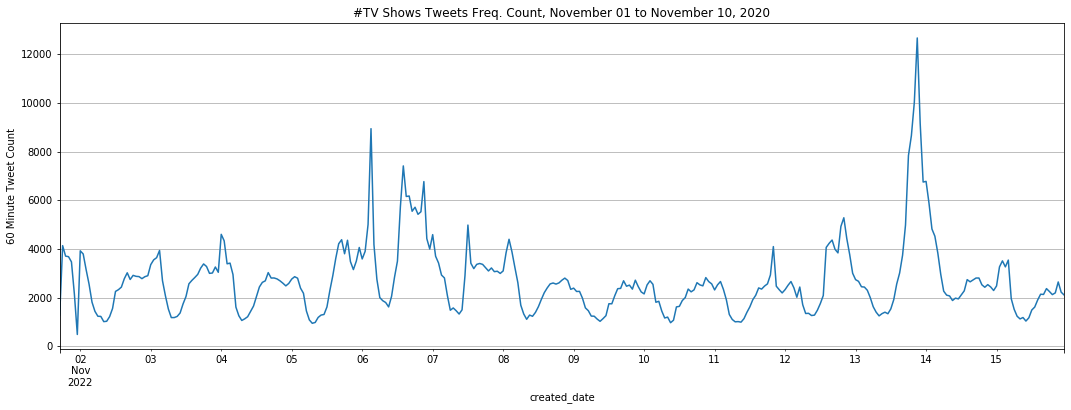

In [81]:
import matplotlib.pyplot as plt
tweet_df_perhour = df_twitter_filtered.groupby(pd.Grouper(key='created_date', freq='60Min', convention='start')).size()
tweet_df_perhour.plot(figsize=(18,6))
plt.ylabel('60 Minute Tweet Count')
plt.title('#TV Shows Tweets Freq. Count, November 01 to November 10, 2020')
plt.grid(True)

### Tweet Preprocessing using preprocessor library in python
##### It supports cleaning, tokenizing and parsing of URLs, Hashtags, Mentions, Reserved words (RT, FAV), Emojis and Smileys

In [3]:
import preprocessor as p
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text)
    return text

In [4]:
df_twitter['tweet'] = df_twitter.apply(preprocess_tweet, axis=1)
# Convert all tweets to lowercase
df_twitter['tweet'] = df_twitter['tweet'].str.lower()

In [6]:
df_twitter.head(5)

,id,tweet
0,1587491421321277441,: if netflix doesnt renew young royals for a s...
1,1587491421300424704,": the nets fired steve nash, sources tell espn."
2,1587491421329686528,run it up !!!
3,1587491429701632001,just like caruso
4,1587491429701632001,just like caruso


### Fetch popular TV Shows from TMDB using their internal API

In [7]:
import requests
total_pages = 1000
base_url = "https://api.themoviedb.org/3/"
api_key = "376f8ca617a6f7be6a758022cbe31465"
popular_tv_shows = []
for page in range(1, total_pages+1):
    tv_change_list_url = base_url+ "tv/popular"+ "?api_key=" + api_key + "&language=en-US&page=" + str(page)
    tv_change_list_response = requests.get(tv_change_list_url).json()
    if tv_change_list_response and 'results' in tv_change_list_response:
        popular_tv_shows.extend(tv_change_list_response['results'])
        print("popular show details for page {} are saved".format(page))
    else:
        break
print(len(popular_tv_shows))

popular show details for page 1 are saved
popular show details for page 2 are saved
popular show details for page 3 are saved
popular show details for page 4 are saved
popular show details for page 5 are saved
popular show details for page 6 are saved
popular show details for page 7 are saved
popular show details for page 8 are saved
popular show details for page 9 are saved
popular show details for page 10 are saved
popular show details for page 11 are saved
popular show details for page 12 are saved
popular show details for page 13 are saved
popular show details for page 14 are saved
popular show details for page 15 are saved
popular show details for page 16 are saved
popular show details for page 17 are saved
popular show details for page 18 are saved
popular show details for page 19 are saved
popular show details for page 20 are saved
popular show details for page 21 are saved
popular show details for page 22 are saved
popular show details for page 23 are saved
popular show details

popular show details for page 191 are saved
popular show details for page 192 are saved
popular show details for page 193 are saved
popular show details for page 194 are saved
popular show details for page 195 are saved
popular show details for page 196 are saved
popular show details for page 197 are saved
popular show details for page 198 are saved
popular show details for page 199 are saved
popular show details for page 200 are saved
popular show details for page 201 are saved
popular show details for page 202 are saved
popular show details for page 203 are saved
popular show details for page 204 are saved
popular show details for page 205 are saved
popular show details for page 206 are saved
popular show details for page 207 are saved
popular show details for page 208 are saved
popular show details for page 209 are saved
popular show details for page 210 are saved
popular show details for page 211 are saved
popular show details for page 212 are saved
popular show details for page 21

popular show details for page 378 are saved
popular show details for page 379 are saved
popular show details for page 380 are saved
popular show details for page 381 are saved
popular show details for page 382 are saved
popular show details for page 383 are saved
popular show details for page 384 are saved
popular show details for page 385 are saved
popular show details for page 386 are saved
popular show details for page 387 are saved
popular show details for page 388 are saved
popular show details for page 389 are saved
popular show details for page 390 are saved
popular show details for page 391 are saved
popular show details for page 392 are saved
popular show details for page 393 are saved
popular show details for page 394 are saved
popular show details for page 395 are saved
popular show details for page 396 are saved
popular show details for page 397 are saved
popular show details for page 398 are saved
popular show details for page 399 are saved
popular show details for page 40

### We are considering top 100 popular TV shows and their hype on Twitter

In [21]:
popular_shows_df = pd.DataFrame(popular_tv_shows)
top_fifty_popular_shows = popular_shows_df.head(100)
top_fifty_popular_shows = top_fifty_popular_shows[['id', 'name']]

In [22]:
top_fifty_popular_shows.to_pickle('tmdb_tvshows.pkl')

In [23]:
popular_shows_df = pd.read_pickle('tmdb_tvshows.pkl')

In [24]:
top_show_names = popular_shows_df['name'].unique()
top_show_names = list((map(lambda x: x.lower(), top_show_names)))

In [25]:
top_show_names

['1899',
 'chucky',
 'the walking dead',
 'cara e coragem',
 'travessia',
 'mar do sertão',
 'now what',
 'sangue oculto',
 'the peripheral',
 'elite',
 'chainsaw man',
 'game of wisdom',
 'strictly come dancing: it takes two',
 'lisa',
 "grey's anatomy",
 'farma',
 'rick and morty',
 'house of the dragon',
 'haireta mou ton platano',
 'spy x family',
 'la reina del sur',
 'cuomo',
 'poliana moça',
 'euronews hoy',
 'dahmer – monster: the jeffrey dahmer story',
 'yellowstone',
 'game of thrones',
 'maria clara and ibarra',
 'the lord of the rings: the rings of power',
 'een jaar van je leven',
 'lucifer',
 'banni chow home delivery',
 'star wars: andor',
 'big brother',
 'miraculous: tales of ladybug & cat noir',
 'the good doctor',
 'the lord of the skies',
 'love is in the air',
 'amai choubatsu: watashi wa kanshu senyou pet',
 'peaky blinders',
 'scoop',
 'star academy',
 'faltu',
 'darna',
 'for you',
 'the vampire diaries',
 "guillermo del toro's cabinet of curiosities",
 'suits',

### Count the number of tweets in which a specific TV show is mentioned & count the frequency for each show

In [26]:
import re
frequency_of_tweets = {}
for tv_show in top_show_names:
    frequency_of_tweets[tv_show] = df_twitter[df_twitter['tweet'].str.contains(tv_show, flags=re.IGNORECASE, regex=True)].shape[0]

sorted_dict_tv_show_frequency = dict( sorted(frequency_of_tweets.items(),
                           key=lambda item: item[1],
                           reverse=True))

In [100]:
sorted_dict_tv_show_frequency.pop('house', 'None')
sorted_dict_tv_show_frequency

{'stranger things': 7431,
 'lisa': 6520,
 'for you': 4789,
 'game of thrones': 4218,
 'the simpsons': 3461,
 'vikings': 3078,
 'breaking bad': 2501,
 'now what': 2138,
 'the walking dead': 1954,
 'wednesday': 1499,
 'house of the dragon': 1264,
 'titans': 1263,
 'elite': 1249,
 'supernatural': 1210,
 'spy x family': 957,
 'manifest': 592,
 'american horror story': 570,
 'criminal minds': 508,
 'rick and morty': 469,
 'chainsaw man': 433,
 'euphoria': 407,
 "grey's anatomy": 355,
 'the boss': 318,
 'big brother': 300,
 'suits': 288,
 'bones': 268,
 'yellowstone': 265,
 'if only': 257,
 'peaky blinders': 224,
 'halo': 213,
 'doctors': 211,
 'the vampire diaries': 192,
 'riverdale': 180,
 'the good doctor': 155,
 'the flash': 150,
 'scoop': 139,
 'chucky': 133,
 'the peripheral': 131,
 'lucifer': 122,
 'the blacklist': 109,
 'cobra kai': 93,
 'all of us are dead': 82,
 'dragon ball z': 75,
 'pbs newshour': 59,
 'the mentalist': 56,
 'hollyoaks': 49,
 'fear the walking dead': 47,
 'the win

### Consider Top 20 TV Shows based on tweet frequency to calculate polarity of tweets for a particular show

In [101]:
import itertools 
top_tv_shows = dict(itertools.islice(sorted_dict_tv_show_frequency.items(), 20)) 

### For each TV show, create a separate dataframe to store the respective tweets

In [102]:
list_of_dfs = {}
for key, value in top_tv_shows.items():
    df_name = '_'.join(key.split()) + '_df'
    list_of_dfs[df_name]  = df_twitter[df_twitter['tweet'].str.contains(key, flags=re.IGNORECASE, regex=True)]

In [30]:
list_of_dfs.keys()

dict_keys(['house_df', 'stranger_things_df', 'lisa_df', 'for_you_df', 'game_of_thrones_df', 'the_simpsons_df', 'vikings_df', 'breaking_bad_df', 'now_what_df', 'the_walking_dead_df', 'wednesday_df', 'house_of_the_dragon_df', 'titans_df', 'elite_df', 'supernatural_df', 'spy_x_family_df', 'manifest_df', 'american_horror_story_df', 'criminal_minds_df', 'rick_and_morty_df'])

#### For each TV Show, we calculate polarity score (positive, negative, neutral) for all its tweets 

In [106]:
from nltk.sentiment import SentimentIntensityAnalyzer
for df_name in list_of_dfs.keys():
    analyzer = SentimentIntensityAnalyzer()
    list_of_dfs[df_name]['rating'] = list_of_dfs[df_name]['tweet'].apply(analyzer.polarity_scores)
    list_of_dfs[df_name] = pd.concat([list_of_dfs[df_name].drop(['rating'], axis=1), list_of_dfs[df_name]['rating'].apply(pd.Series)], axis=1)

C:\Users\Aakarsha Chug\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Based on the polarity scores, we mark the hype of the tweet as positive, negative and neutral

In [107]:
def calculate_hype(row):
    if (row['neg'] >= row['neu']) and (row['neg'] >= row['pos']):
        largest = 'negative'
  
    elif (row['pos'] >= row['neg']) and (row['pos'] >= row['neu']):
        largest = 'positive'
    
    elif(row['neu'] - row['neg'] <= 0.5):
        largest = 'negative'
    elif(row['neu'] - row['pos'] <= 0.5):
        largest = 'positive'
    else:
        largest = 'neutral'
          
    return largest

In [108]:
for df_name in list_of_dfs.keys():
    list_of_dfs[df_name]['hype'] = list_of_dfs[df_name].apply(calculate_hype, axis=1)

#### For instance, for TV Show : Stranger Things the dataframe looks something like this...

In [109]:
list_of_dfs['stranger_things_df']

,id,tweet,author_id,created_date,tweet_date,neg,neu,pos,compound,hype
535,1587501860952240129,RT @Stranger_Things: halloween is over --&gt; ...,175574045,2022-11-01 17:48:38.713,2022-11-01,0.000,1.00,0.000,0.0000,neutral
536,1587501860952240129,RT @Stranger_Things: halloween is over --&gt; ...,175574045,2022-11-01 17:48:38.726,2022-11-01,0.000,1.00,0.000,0.0000,neutral
537,1587501860952240129,RT @Stranger_Things: halloween is over --&gt; ...,175574045,2022-11-01 17:48:38.738,2022-11-01,0.000,1.00,0.000,0.0000,neutral
538,1587501860952240129,RT @Stranger_Things: halloween is over --&gt; ...,175574045,2022-11-01 17:48:38.750,2022-11-01,0.000,1.00,0.000,0.0000,neutral
833,1587503043708346372,"RT @Stranger_Things: cancel your plans, call y...",1421884363592065025,2022-11-01 17:53:20.377,2022-11-01,0.072,0.83,0.097,0.1779,neutral
...,...,...,...,...,...,...,...,...,...,...
1057873,1596608588319195136,@iAmTheRoKK That’s next on my list after Stran...,103162079,2022-11-26 20:55:31.444,2022-11-26,0.000,1.00,0.000,0.0000,neutral
1057874,1596608588319195136,@iAmTheRoKK That’s next on my list after Stran...,103162079,2022-11-26 20:55:31.448,2022-11-26,0.000,1.00,0.000,0.0000,neutral
1059155,1596611868235558913,"RT @MockingbirdUK: MATTHEW MODINE, Golden Glob...",864641958693801984,2022-11-26 21:08:33.512,2022-11-26,0.000,0.84,0.160,0.5859,neutral
1059156,1596611868235558913,"RT @MockingbirdUK: MATTHEW MODINE, Golden Glob...",864641958693801984,2022-11-26 21:08:33.520,2022-11-26,0.000,0.84,0.160,0.5859,neutral


### Caluclate the number of positive, negative and neutral tweets for all TV Top 20 TV shows

In [110]:
tv_shows_polarity_frequency = []
for df_name in list_of_dfs.keys():
    frequency_values = list_of_dfs[df_name]['hype'].value_counts()
    frequency_values_dict = {'show_name': df_name, 'neutral' : frequency_values['neutral'], 'positive': frequency_values['positive'], 'negative': frequency_values['negative'] }
    tv_shows_polarity_frequency.append(frequency_values_dict)
tv_shows_polarity_frequency_df = pd.DataFrame(tv_shows_polarity_frequency)

In [116]:
tv_shows_polarity_frequency_df.head(20)

,show_name,neutral,positive,negative
0,stranger_things_df,6395,899,151
1,lisa_df,4460,6222,152
2,for_you_df,2776,1807,330
3,game_of_thrones_df,2824,1272,165
4,the_simpsons_df,3229,107,178
5,vikings_df,3933,862,604
6,breaking_bad_df,989,83,1482
7,now_what_df,1643,308,233
8,the_walking_dead_df,452,19,1507
9,wednesday_df,1588,182,62


### Visualizing for Top 10 Popular TV Shows based on their Positive and Negative Hype

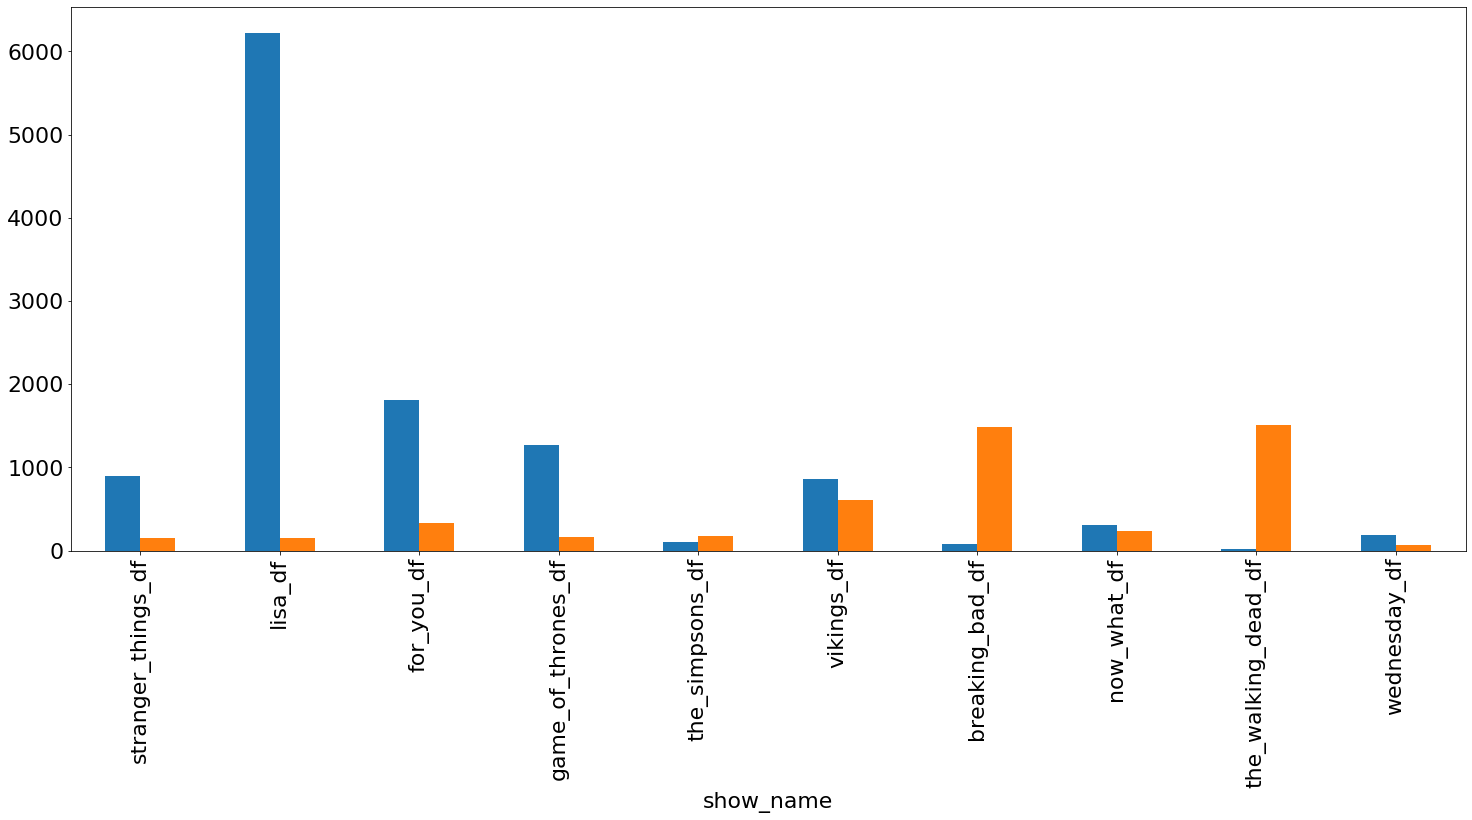

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
tv_shows_polarity_frequency_df_plot = tv_shows_polarity_frequency_df.head(10)
plt.rcParams["figure.figsize"] = (25,10)
plt.rcParams.update({'font.size': 22})
tv_shows_polarity_frequency_df_plot.plot(x='show_name', y=['positive', 'negative'], kind='bar', legend=False)
plt.show()